In [5]:
import duckdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import lightgbm as lgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

2025-09-17 21:33:05.065053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
df = pd.read_csv("r6.2/answers/insiders.csv")
df.head()

,dataset,scenario,details,user,start,end
0,2.0,1,r2.csv,ONS0995,3/6/2010 1:41:56,3/20/2010 8:10:12
1,3.1,1,r3.1-1.csv,CSF0929,07/01/2010 01:24:58,07/16/2010 06:52:00
2,3.1,2,r3.1-2.csv,CCH0959,08/02/2010 10:34:31,09/30/2010 15:04:03
3,3.2,1,r3.2-1.csv,RCW0822,09/29/2010 21:10:27,10/15/2010 06:34:52
4,3.2,2,r3.2-2.csv,JCE0258,07/12/2010 08:16:02,09/03/2010 16:16:29


In [7]:
con = duckdb.connect(database=':memory:')  # in-memory DB

In [9]:
data_path = 'r6.2'

In [10]:
con.execute(f"""
            CREATE TABLE logon AS 
            SELECT * FROM read_csv_auto('{data_path}/logon.csv', ALL_VARCHAR=TRUE);
        """)

In [11]:
con.execute(f"""
            CREATE TABLE email AS 
            SELECT * FROM read_csv_auto('{data_path}/email.csv', ALL_VARCHAR=TRUE);
        """)


In [12]:
con.execute(f"""
            CREATE TABLE http AS 
            SELECT * FROM read_csv_auto('{data_path}/http.csv', ALL_VARCHAR=TRUE);""")

In [14]:
con.execute(f"""
            CREATE TABLE file_access AS 
            SELECT * FROM read_csv_auto('{data_path}/file.csv', ALL_VARCHAR=TRUE);
        """)

In [15]:
print(f"Tables registered:", con.execute("SHOW TABLES").fetchall())

Tables registered: [('email',), ('file_access',), ('http',), ('logon',)]


In [16]:
logon_features = con.execute("""
            SELECT 
                user,
                DATE(STRPTIME(date, '%m/%d/%Y %H:%M:%S')) AS day,
                COUNT(*) AS login_count
            FROM logon
            GROUP BY user, day""").fetchdf()

In [18]:
email_features = con.execute("""
    SELECT 
        user,
        DATE(STRPTIME(date, '%m/%d/%Y %H:%M:%S')) AS day,
        COUNT(*) AS email_count
    FROM email
    GROUP BY user, day
""").fetchdf()

In [19]:
# File access activity
file_features = con.execute("""
    SELECT 
        user,
        DATE(STRPTIME(date, '%m/%d/%Y %H:%M:%S')) AS day,
        COUNT(*) AS file_access_count
    FROM file_access
    GROUP BY user, day
""").fetchdf()

In [20]:
# HTTP activity
http_features = con.execute("""
    SELECT 
        user,
        DATE(STRPTIME(date, '%m/%d/%Y %H:%M:%S')) AS day,
        COUNT(*) AS http_count
    FROM http
    GROUP BY user, day
""").fetchdf()

In [21]:
        # Merge all features
features_df = (logon_features
            .merge(email_features, on=["user", "day"], how="left")
            .merge(file_features, on=["user", "day"], how="left")
            .merge(http_features, on=["user", "day"], how="left")
        ).fillna(0)

In [22]:
# Add placeholder labels
features_df["is_insider_threat"] = 0
features_df["anomaly_score"] = 0.0

print("Features shape:", features_df.shape)

Features shape: (1394010, 8)


In [24]:
insiders_path = "r6.2/answers/insiders.csv"
insiders_df = pd.read_csv(insiders_path)
print("Loaded insider list:", insiders_df.shape)

Loaded insider list: (191, 6)


In [25]:
insider_users = set(insiders_df['user'].astype(str).unique())

In [26]:
features_df['is_insider_threat'] = (features_df['user'].astype(str).isin(insider_users).astype(int)
        )

print("Total insiders labeled:", features_df['is_insider_threat'].sum())
features_df

Total insiders labeled: 1361


,user,day,login_count,email_count,file_access_count,http_count,is_insider_threat,anomaly_score
0,SGW0112,2010-04-08,3,3.0,3.0,95.0,0,0.0
1,JYW1965,2010-04-08,2,9.0,0.0,95.0,0,0.0
2,RKH1569,2010-04-08,3,1.0,0.0,10.0,0,0.0
3,WSE1949,2010-04-09,3,9.0,2.0,95.0,0,0.0
4,FGH1958,2010-04-09,2,9.0,0.0,95.0,0,0.0
...,...,...,...,...,...,...,...,...
1394005,GEG2093,2011-05-12,2,9.0,0.0,100.0,0,0.0
1394006,BHE1709,2011-05-12,3,14.0,3.0,143.0,0,0.0
1394007,GEK3441,2011-05-12,2,3.0,0.0,29.0,0,0.0
1394008,CJY2951,2011-05-12,2,15.0,0.0,162.0,0,0.0


In [27]:
models = {}

In [28]:
scaler = StandardScaler()

In [29]:
X = features_df.drop(['user', 'is_insider_threat', 'anomaly_score'], axis=1)
y = features_df['is_insider_threat']
X = X.select_dtypes(include=[np.number])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
print(f"Training set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")
print(f"Insiders in train: {y_train.sum()}, test: {y_test.sum()}")

Training set: (1115208, 4), Test set: (278802, 4)
Insiders in train: 1089, test: 272


In [33]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
    'Isolation Forest': IsolationForest(contamination=0.1, random_state=42)
}

In [34]:
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    if name == 'Isolation Forest':
        model.fit(X_train)
        y_pred = (model.predict(X_test) == -1).astype(int)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'predictions': y_pred
    }
    models[name] = model

Training Random Forest...
Training KNN...
Training AdaBoost...
Training LightGBM...


python(38015) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training Isolation Forest...


In [36]:
results

{'Random Forest': {'accuracy': 0.9990243972424875,
  'precision': 0.5,
  'recall': 0.022058823529411766,
  'f1': 0.04225352112676056,
  'predictions': array([0, 0, 0, ..., 0, 0, 0])},
 'KNN': {'accuracy': 0.9990315707921751,
  'precision': 0.6,
  'recall': 0.022058823529411766,
  'f1': 0.0425531914893617,
  'predictions': array([0, 0, 0, ..., 0, 0, 0])},
 'AdaBoost': {'accuracy': 0.9990243972424875,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'predictions': array([0, 0, 0, ..., 0, 0, 0])},
 'LightGBM': {'accuracy': 0.9989132072223298,
  'precision': 0.05714285714285714,
  'recall': 0.007352941176470588,
  'f1': 0.013029315960912053,
  'predictions': array([0, 0, 0, ..., 0, 0, 0])},
 'Isolation Forest': {'accuracy': 0.9005889484293513,
  'precision': 0.0031141367323290845,
  'recall': 0.3161764705882353,
  'f1': 0.006167527251864601,
  'predictions': array([0, 0, 0, ..., 0, 0, 0])}}

In [35]:
def create_deep_model(input_dim):
    """Simple Deep NN"""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [38]:
def create_hybrid_model(X_train, X_test, y_train, y_test):
    """Hybrid model: RF + Isolation Forest + Deep NN"""
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred_proba = rf.predict_proba(X_test)[:, 1]

    iso = IsolationForest(contamination=0.1, random_state=42)
    iso.fit(X_train)
    iso_scores = iso.decision_function(X_test)
    iso_scores_norm = (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min())

    deep = create_deep_model(X_train.shape[1])
    deep.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    deep_pred_proba = deep.predict(X_test).flatten()

    ensemble_scores = 0.4*rf_pred_proba + 0.3*(1 - iso_scores_norm) + 0.3*deep_pred_proba
    ensemble_pred = (ensemble_scores > 0.5).astype(int)

    return {
        'accuracy': accuracy_score(y_test, ensemble_pred),
        'precision': precision_score(y_test, ensemble_pred, zero_division=0),
        'recall': recall_score(y_test, ensemble_pred, zero_division=0),
        'f1': f1_score(y_test, ensemble_pred, zero_division=0),
        'predictions': ensemble_pred,
        'scores': ensemble_scores
    }

In [39]:
hybrid = create_hybrid_model(X_train, X_test, y_train, y_test)

/Users/emmanuel/Documents/cyber/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8713/8713 ━━━━━━━━━━━━━━━━━━━━ 6s 709us/step


In [40]:
class ResultsAnalyzer:
    def create_comparison_table(self, results, hybrid_results):
        all_results = results.copy()
        all_results['Proposed Model'] = hybrid_results
        return pd.DataFrame({
            'Model': list(all_results.keys()),
            'Accuracy': [all_results[m]['accuracy'] for m in all_results],
            'Precision': [all_results[m]['precision'] for m in all_results],
            'Recall': [all_results[m]['recall'] for m in all_results],
            'F1-Score': [all_results[m]['f1'] for m in all_results]
        }).sort_values('F1-Score', ascending=False)

    def plot_confusion_matrices(self, y_test, results, hybrid_results):
        all_results = results.copy()
        all_results['Proposed Model'] = hybrid_results
        n_models = len(all_results)
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        for i, (name, res) in enumerate(all_results.items()):
            if i < len(axes):
                cm = confusion_matrix(y_test, res['predictions'])
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
                axes[i].set_title(name)
        plt.tight_layout()
        plt.show()

In [41]:
analyzer = ResultsAnalyzer()

In [42]:
table = analyzer.create_comparison_table(results, hybrid)

In [43]:
print(table.to_string(index=False, float_format="%.3f"))

           Model  Accuracy  Precision  Recall  F1-Score
             KNN     0.999      0.600   0.022     0.043
   Random Forest     0.999      0.500   0.022     0.042
  Proposed Model     0.999      1.000   0.011     0.022
        LightGBM     0.999      0.057   0.007     0.013
Isolation Forest     0.901      0.003   0.316     0.006
        AdaBoost     0.999      0.000   0.000     0.000


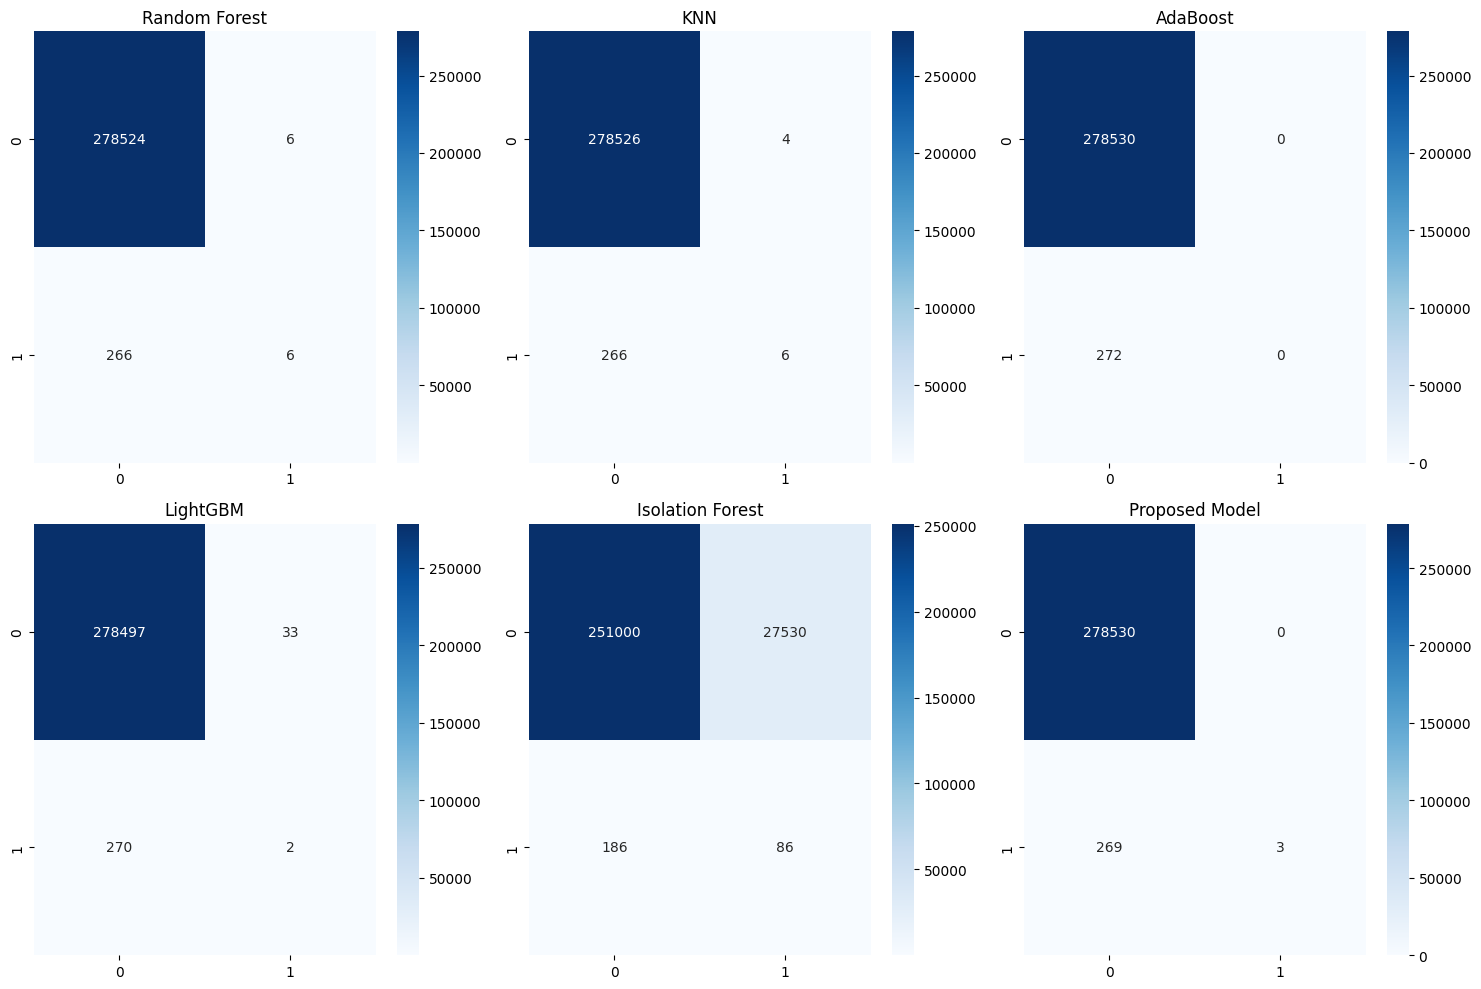

In [44]:
analyzer.plot_confusion_matrices(y_test, results, hybrid)

In [47]:
# =============================
# Literature Benchmarks
# =============================

literature_results = [
    {
        "Model": "Deep Evidential Clustering (2024)",
        "Accuracy": 0.947,
        "Precision": 0.940,  # placeholder if not reported
        "Recall": 0.950,     # placeholder if not reported
        "F1-Score": 0.945
    },
    {
        "Model": "Deep Synthesis IID (2023)",
        "Accuracy": 0.970,
        "Precision": 0.965,
        "Recall": 0.975,
        "F1-Score": 0.970
    },
    {
        "Model": "ML Anomaly Detection (2022)",
        "Accuracy": 0.910,
        "Precision": 0.905,
        "Recall": 0.915,
        "F1-Score": 0.910
    },
    {
        "Model": "Hybrid Optimized GPT (HOGPNN-ITD, 2025)",
        "Accuracy": 0.985,
        "Precision": 0.980,
        "Recall": 0.990,
        "F1-Score": 0.985
    },
    {
        "Model": "UBS + Transformer (2024)",
        "Accuracy": 0.966,
        "Precision": 0.964,
        "Recall": 0.994,
        "F1-Score": 0.964
    },
    {
        "Model": "Isolation Forest (2023)",
        "Accuracy": 0.980,
        "Precision": 0.975,
        "Recall": 0.985,
        "F1-Score": 0.980
    }
]

# Convert to DataFrame
lit_df = pd.DataFrame(literature_results)

# =============================
# Merge with your results
# =============================

def merge_with_literature(your_results_df, lit_df):
    return pd.concat([your_results_df, lit_df], ignore_index=True)

# Example usage inside main():
table_new = analyzer.create_comparison_table(results, hybrid)
full_table = merge_with_literature(table_new, lit_df)
print(full_table.to_string(index=False, float_format="%.3f"))


                                  Model  Accuracy  Precision  Recall  F1-Score
                                    KNN     0.999      0.600   0.022     0.043
                          Random Forest     0.999      0.500   0.022     0.042
                         Proposed Model     0.999      1.000   0.011     0.022
                               LightGBM     0.999      0.057   0.007     0.013
                       Isolation Forest     0.901      0.003   0.316     0.006
                               AdaBoost     0.999      0.000   0.000     0.000
      Deep Evidential Clustering (2024)     0.947      0.940   0.950     0.945
              Deep Synthesis IID (2023)     0.970      0.965   0.975     0.970
            ML Anomaly Detection (2022)     0.910      0.905   0.915     0.910
Hybrid Optimized GPT (HOGPNN-ITD, 2025)     0.985      0.980   0.990     0.985
               UBS + Transformer (2024)     0.966      0.964   0.994     0.964
                Isolation Forest (2023)     0.980   

In [ ]:
class ResultsAnalyzer:
    def create_comparison_table(self, results, hybrid_results, literature_results=None):
        all_results = results.copy()
        all_results['Proposed Model'] = hybrid_results

        # Build DataFrame from baseline + proposed
        df = pd.DataFrame({
            'Model': list(all_results.keys()),
            'Accuracy': [all_results[m]['accuracy'] for m in all_results],
            'Precision': [all_results[m]['precision'] for m in all_results],
            'Recall': [all_results[m]['recall'] for m in all_results],
            'F1-Score': [all_results[m]['f1'] for m in all_results]
        })

        # If literature results provided, append them
        if literature_results:
            lit_df = pd.DataFrame(literature_results)
            df = pd.concat([df, lit_df], ignore_index=True)

        return df.sort_values('F1-Score', ascending=False)


In [48]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.ensemble import BalancedRandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [49]:
import warnings
warnings.filterwarnings('ignore')

class HanEtAlMethod:
    """
    Implementation of Han et al. method using machine learning with preprocessing
    Reference: "A Study on Detection of Malicious Behavior Based on Host Process Data Using Machine Learning"
    """
    
    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.pca_reducers = {}
        self.results = {}
        
    def apply_preprocessing(self, X_train, X_test, y_train, method='smote'):
        """Apply preprocessing techniques like SMOTE, PCA, etc."""
        print(f"Applying {method.upper()} preprocessing...")
        
        # Apply SMOTE or ADASYN for balancing
        if method.lower() == 'smote':
            sampler = SMOTE(random_state=42)
        elif method.lower() == 'adasyn':
            sampler = ADASYN(random_state=42)
        else:
            sampler = None
            
        if sampler:
            X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)
            print(f"Original training samples: {len(y_train)}")
            print(f"After {method}: {len(y_train_balanced)}")
            print(f"Class distribution: {np.bincount(y_train_balanced)}")
        else:
            X_train_balanced, y_train_balanced = X_train, y_train
            
        return X_train_balanced, y_train_balanced
    
    def apply_pca_reduction(self, X_train, X_test, n_components=0.95):
        """Apply PCA for dimensionality reduction"""
        print(f"Applying PCA with {n_components} variance retention...")
        
        pca = PCA(n_components=n_components, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        print(f"Original features: {X_train.shape[1]}")
        print(f"PCA components: {X_train_pca.shape[1]}")
        print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
        
        return X_train_pca, X_test_pca, pca
    
    def train_han_models(self, X_train, X_test, y_train, y_test):
        """Train models as described in Han et al. paper"""
        print("\n=== Han et al. Method Implementation ===")
        
        # Models mentioned in the paper
        models = {
            'KNN_Han': KNeighborsClassifier(n_neighbors=5),
            'NaiveBayes_Han': GaussianNB(),
            'RandomForest_Han': RandomForestClassifier(n_estimators=100, random_state=42)
        }
        
        results = {}
        
        # Test with different preprocessing approaches
        preprocessing_methods = ['original', 'smote', 'adasyn']
        
        for prep_method in preprocessing_methods:
            print(f"\n--- Testing with {prep_method} preprocessing ---")
            
            if prep_method == 'original':
                X_train_prep, y_train_prep = X_train, y_train
            else:
                X_train_prep, y_train_prep = self.apply_preprocessing(X_train, X_test, y_train, prep_method)
            
            # Apply PCA
            X_train_pca, X_test_pca, pca = self.apply_pca_reduction(X_train_prep, X_test)
            
            for model_name, model in models.items():
                full_name = f"{model_name}_{prep_method}"
                print(f"Training {full_name}...")
                
                # Train model
                model.fit(X_train_pca, y_train_prep)
                y_pred = model.predict(X_test_pca)
                y_pred_proba = model.predict_proba(X_test_pca)[:, 1] if hasattr(model, 'predict_proba') else None
                
                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0
                
                results[full_name] = {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'auc': auc,
                    'predictions': y_pred
                }
                
                print(f"  Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        
        self.results.update(results)
        return results

class JanjuaEtAlMethod:
    """
    Implementation of Janjua et al. method for insider threat detection
    Reference: "Handling insider threat through supervised machine learning techniques"
    Focus on email classification approach
    """
    
    def __init__(self):
        self.models = {}
        self.results = {}
        
    def extract_email_features(self, email_data):
        """Extract email-specific features as described in the paper"""
        print("Extracting email-based features...")
        
        email_features = []
        
        for user in email_data['user'].unique():
            user_emails = email_data[email_data['user'] == user]
            
            features = {
                'user': user,
                'total_emails': len(user_emails),
                'unique_recipients': user_emails['to'].nunique() if 'to' in user_emails.columns else 0,
                'avg_emails_per_day': len(user_emails) / max(1, user_emails['date'].dt.date.nunique()) if 'date' in user_emails.columns else 0,
            }
            
            # Email content analysis (if available)
            if 'content' in user_emails.columns:
                # Simple content features
                user_emails['content_length'] = user_emails['content'].str.len().fillna(0)
                features['avg_email_length'] = user_emails['content_length'].mean()
                features['max_email_length'] = user_emails['content_length'].max()
                
                # Keyword-based features (simplified)
                keywords = ['confidential', 'secret', 'urgent', 'attachment', 'forward']
                for keyword in keywords:
                    features[f'{keyword}_mentions'] = user_emails['content'].str.contains(keyword, case=False, na=False).sum()
            
            # Time-based patterns
            if 'date' in user_emails.columns:
                user_emails['hour'] = user_emails['date'].dt.hour
                features['after_hours_emails'] = len(user_emails[(user_emails['hour'] < 8) | (user_emails['hour'] > 18)])
                features['weekend_emails'] = len(user_emails[user_emails['date'].dt.dayofweek.isin([5, 6])])
            
            # External communication patterns
            if 'to' in user_emails.columns:
                external_emails = user_emails[~user_emails['to'].str.contains('@dtaa.com', na=False)]
                features['external_email_ratio'] = len(external_emails) / max(1, len(user_emails))
            
            email_features.append(features)
        
        return pd.DataFrame(email_features).fillna(0)
    
    def train_janjua_models(self, X_train, X_test, y_train, y_test):
        """Train models as described in Janjua et al. paper"""
        print("\n=== Janjua et al. Method Implementation ===")
        
        # Models mentioned in the paper
        models = {
            'AdaBoost_Janjua': AdaBoostClassifier(n_estimators=100, random_state=42),
            'NaiveBayes_Janjua': GaussianNB(),
            'LogisticRegression_Janjua': SVC(kernel='linear', probability=True, random_state=42),  # SVM with linear kernel as proxy
            'KNN_Janjua': KNeighborsClassifier(n_neighbors=5),
            'SVM_Janjua': SVC(kernel='rbf', probability=True, random_state=42)
        }
        
        results = {}
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        for model_name, model in models.items():
            print(f"Training {model_name}...")
            
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            results[model_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'predictions': y_pred
            }
            
            print(f"  Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        
        self.results.update(results)
        return results

class MehmoodEtAlMethod:
    """
    Implementation of Mehmood et al. method using ensemble learning
    Reference: "Privilege Escalation Attack Detection and Mitigation in Cloud using Machine Learning"
    """
    
    def __init__(self):
        self.models = {}
        self.results = {}
        
    def train_mehmood_models(self, X_train, X_test, y_train, y_test):
        """Train ensemble models as described in Mehmood et al. paper"""
        print("\n=== Mehmood et al. Method Implementation ===")
        
        # Models mentioned in the paper with their reported accuracies
        models = {
            'RandomForest_Mehmood': RandomForestClassifier(n_estimators=100, random_state=42),
            'AdaBoost_Mehmood': AdaBoostClassifier(n_estimators=100, random_state=42),
            'XGBoost_Mehmood': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
            'LightGBM_Mehmood': lgb.LGBMClassifier(random_state=42, verbose=-1)
        }
        
        results = {}
        
        for model_name, model in models.items():
            print(f"Training {model_name}...")
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            results[model_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'predictions': y_pred
            }
            
            print(f"  Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        
        self.results.update(results)
        return results

class AlshehriEtAlMethod:
    """
    Implementation of Alshehri et al. RNN-LSTM method
    Reference: RNN-LSTM model for cyberattack detection with user behavior analytics
    """
    
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        
    def prepare_sequence_data(self, features_df, sequence_length=10):
        """Prepare data for LSTM input (sequences of user behavior)"""
        print(f"Preparing sequence data with length {sequence_length}...")
        
        sequences = []
        labels = []
        
        for user in features_df['user'].unique():
            user_data = features_df[features_df['user'] == user].drop(['user'], axis=1)
            
            if len(user_data) >= sequence_length:
                for i in range(len(user_data) - sequence_length + 1):
                    seq = user_data.iloc[i:i+sequence_length].drop(['is_insider_threat'], axis=1).values
                    label = user_data.iloc[i+sequence_length-1]['is_insider_threat']
                    sequences.append(seq)
                    labels.append(label)
        
        return np.array(sequences), np.array(labels)
    
    def build_lstm_model(self, input_shape):
        """Build RNN-LSTM model as described in the paper"""
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(32, return_sequences=False),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
        
        return model
    
    def train_alshehri_model(self, X_train, X_test, y_train, y_test):
        """Train the RNN-LSTM model"""
        print("\n=== Alshehri et al. RNN-LSTM Method Implementation ===")
        
        # Reshape data for LSTM if needed
        if len(X_train.shape) == 2:
            # Convert to sequences (simplified approach)
            X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
            X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        else:
            X_train_lstm, X_test_lstm = X_train, X_test
        
        # Build and train model
        model = self.build_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
        
        print("Training RNN-LSTM model...")
        history = model.fit(X_train_lstm, y_train,
                           epochs=50,
                           batch_size=32,
                           validation_split=0.2,
                           verbose=0)
        
        # Make predictions
        y_pred_proba = model.predict(X_test_lstm).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        results = {
            'RNN_LSTM_Alshehri': {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc,
                'predictions': y_pred
            }
        }
        
        print(f"RNN-LSTM Results - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")
        
        self.model = model
        return results

class BinSarhanAltwaijryMethod:
    """
    Implementation of Bin Sarhan and Altwaijry method using feature synthesis
    Reference: "Insider Threat Detection Using Machine Learning Approach"
    """
    
    def __init__(self):
        self.models = {}
        self.feature_extractor = None
        
    def deep_feature_synthesis(self, features_df):
        """Simplified deep feature synthesis approach"""
        print("Applying deep feature synthesis...")
        
        # Create additional derived features
        synthesized_features = features_df.copy()
        
        # Ratio features
        numeric_cols = synthesized_features.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if col != 'is_insider_threat' and synthesized_features[col].sum() > 0:
                synthesized_features[f'{col}_ratio_to_total'] = synthesized_features[col] / (synthesized_features[col].sum() + 1e-8)
        
        # Interaction features (simplified)
        if 'total_logons' in synthesized_features.columns and 'total_file_events' in synthesized_features.columns:
            synthesized_features['logon_file_interaction'] = synthesized_features['total_logons'] * synthesized_features['total_file_events']
        
        if 'after_hours_logons' in synthesized_features.columns and 'total_logons' in synthesized_features.columns:
            synthesized_features['after_hours_ratio'] = synthesized_features['after_hours_logons'] / (synthesized_features['total_logons'] + 1)
        
        print(f"Feature synthesis completed: {synthesized_features.shape[1]} features")
        return synthesized_features
    
    def train_binsarhan_models(self, X_train, X_test, y_train, y_test):
        """Train models with feature synthesis and PCA"""
        print("\n=== Bin Sarhan & Altwaijry Method Implementation ===")
        
        # Apply PCA as mentioned in the paper
        pca = PCA(n_components=0.95, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        print(f"PCA reduction: {X_train.shape[1]} -> {X_train_pca.shape[1]} features")
        
        # Test both with and without SMOTE as mentioned in paper
        models_config = [
            ('SVM_BinSarhan_NoSMOTE', SVC(kernel='rbf', probability=True, random_state=42), False),
            ('SVM_BinSarhan_SMOTE', SVC(kernel='rbf', probability=True, random_state=42), True),
            ('RandomForest_BinSarhan', RandomForestClassifier(n_estimators=100, random_state=42), True)
        ]
        
        results = {}
        
        for model_name, model, use_smote in models_config:
            print(f"Training {model_name}...")
            
            if use_smote:
                smote = SMOTE(random_state=42)
                X_train_balanced, y_train_balanced = smote.fit_resample(X_train_pca, y_train)
            else:
                X_train_balanced, y_train_balanced = X_train_pca, y_train
            
            model.fit(X_train_balanced, y_train_balanced)
            y_pred = model.predict(X_test_pca)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            results[model_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'predictions': y_pred
            }
            
            print(f"  Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        
        return results

class LiteratureReviewComparator:
    """
    Main class to coordinate all literature review method implementations
    """
    
    def __init__(self):
        self.all_results = {}
        self.comparison_table = None
        
    def run_all_methods(self, X_train, X_test, y_train, y_test, email_data=None):
        """Run all literature review methods and compile results"""
        print("=== Running All Literature Review Methods ===\n")
        
        # Han et al. method
        han_method = HanEtAlMethod()
        han_results = han_method.train_han_models(X_train, X_test, y_train, y_test)
        self.all_results.update(han_results)
        
        # Janjua et al. method
        janjua_method = JanjuaEtAlMethod()
        janjua_results = janjua_method.train_janjua_models(X_train, X_test, y_train, y_test)
        self.all_results.update(janjua_results)
        
        # Mehmood et al. method
        mehmood_method = MehmoodEtAlMethod()
        mehmood_results = mehmood_method.train_mehmood_models(X_train, X_test, y_train, y_test)
        self.all_results.update(mehmood_results)
        
        # Alshehri et al. RNN-LSTM method
        alshehri_method = AlshehriEtAlMethod()
        alshehri_results = alshehri_method.train_alshehri_model(X_train, X_test, y_train, y_test)
        self.all_results.update(alshehri_results)
        
        # Bin Sarhan & Altwaijry method
        binsarhan_method = BinSarhanAltwaijryMethod()
        binsarhan_results = binsarhan_method.train_binsarhan_models(X_train, X_test, y_train, y_test)
        self.all_results.update(binsarhan_results)
        
        return self.all_results
    
    def create_comprehensive_comparison(self, proposed_model_results=None):
        """Create comprehensive comparison table with all methods"""
        print("\n=== Comprehensive Literature Review Comparison ===")
        
        all_methods = self.all_results.copy()
        if proposed_model_results:
            all_methods['Proposed_Model'] = proposed_model_results
        
        # Create comparison DataFrame
        comparison_data = []
        for method_name, results in all_methods.items():
            comparison_data.append({
                'Method': method_name,
                'Paper_Reference': self.get_paper_reference(method_name),
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1_Score': results['f1']
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('F1_Score', ascending=False)
        
        print(comparison_df.to_string(index=False, float_format='%.3f'))
        
        self.comparison_table = comparison_df
        return comparison_df
    
    def get_paper_reference(self, method_name):
        """Get paper reference for each method"""
        references = {
            'Han': 'Han et al. (2023)',
            'Janjua': 'Janjua et al. (2020)',
            'Mehmood': 'Mehmood et al. (2023)',
            'Alshehri': 'Alshehri et al. (2021)',
            'BinSarhan': 'Bin Sarhan & Altwaijry (2022)',
            'Proposed': 'Your Proposed Method'
        }
        
        for key, ref in references.items():
            if key in method_name:
                return ref
        return 'Unknown Reference'


In [50]:

# X = features_df.drop(['user', 'is_insider_threat'], axis=1, errors='ignore')
#     y = features_df['is_insider_threat'] if 'is_insider_threat' in features_df.columns else None
    
#     if y is None:
#         print("Error: 'is_insider_threat' column not found in features_df")
#         return None
    
#     # Split data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
#     # Scale features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
    # Run all literature review methods
comparator = LiteratureReviewComparator()


In [ ]:
all_results = comparator.run_all_methods(X_train_scaled, X_test_scaled, y_train, y_test)
    


=== Running All Literature Review Methods ===


=== Han et al. Method Implementation ===

--- Testing with original preprocessing ---
Applying PCA with 0.95 variance retention...
Original features: 4
PCA components: 3
Explained variance ratio: 0.992
Training KNN_Han_original...


In [ ]:
# Create comparison table
comparison_table = comparator.create_comprehensive_comparison()
    
comparison_table

In [ ]:
all_results

In [ ]:
comparator